In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

import xgboost as xgb

import numpy as np
import pandas as pd

from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2
import math
import itertools

from tensorflow import keras
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


In [2]:
MODEL_LOCATION = "../CNN-filter/CNN_filter_model.json"
WEIGHTS_LOCATION = "../CNN-filter/weight-cnn-filter.best_19-0.97.hdf5"


TRAIN_DIRECTORY = "../../data/train/"
TEST_DIRECTORY = "../../data/test/"
IMG_HEIGHT = 70
IMG_WIDTH = 70
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

lwr_hsv = (25,40,50)
upr_hsv = (75,255,255)


# Loading the Data

In [3]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for imag in files:
    
    img = cv2.imread(imag)

    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,lwr_hsv,upr_hsv)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new_img = np.zeros_like(img,np.uint8)
    new_img[boolean] = img[boolean]
    res_img = new_img


    rez_img = cv2.resize(res_img, dsize =(IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
    rez_img = rez_img.reshape(IMG_WIDTH, IMG_HEIGHT, 3)
    trainImg.append(rez_img)
    
    trainLabel.append(imag.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(4750, 70, 70, 3)
(4750, 1)


In [4]:
trainImg = trainImg / 255

le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [5]:
path =  TEST_DIRECTORY + '/*.png'
files = glob(path)

testImg = []
testId = []
num = len(files)

# Obtain images and resizing, obtain labels
for imag in files:
    testId.append(imag.split('/')[-1])  # Images id's
    
    img = cv2.imread(imag)

    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,lwr_hsv,upr_hsv)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new_img = np.zeros_like(img,np.uint8)
    new_img[boolean] = img[boolean]
    res_img = new_img


    rez_img = cv2.resize(res_img, dsize =(IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
    rez_img = rez_img.reshape(IMG_WIDTH, IMG_HEIGHT, 3)
    testImg.append(rez_img)
    
    
    
    

testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)

testImg = testImg / 255


(794, 70, 70, 3)


# Loading the Model

In [ ]:
json_file = open(MODEL_LOCATION, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(WEIGHTS_LOCATION)


# Extracting the features

In [7]:
model_feat = Model(inputs=loaded_model.input,outputs=loaded_model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_valid)
print(feat_val.shape)

feat_test = model_feat.predict(testImg)
print(feat_test.shape)

(3800, 128)
(950, 128)
(794, 128)


# XGBoost Classifier

In [8]:
xb = xgb.XGBClassifier()

xb.fit(feat_train, np.argmax(y_train, axis=1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
xb.score(feat_train,np.argmax(y_train,axis=1))

1.0

In [10]:
xb.score(feat_val, np.argmax(y_valid,axis=1))

0.988421052631579

In [11]:
classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet']

In [12]:
pred = xb.predict(feat_test)
# Write result to file
predStr = []
for c in pred:
    predStr.append(classes[c])
  
predStr = np.asarray(predStr)

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)

# 0.96725


# SVM Classifier

In [13]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
                     'C': [1, 10, 100, 1000]}]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s' % score
    )
    clf.fit(feat_train, np.argmax(y_train, axis=1))

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = np.argmax(y_valid,axis=1), clf.predict(feat_val)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for accuracy



/home/andrei/ml/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.961 (+/-0.013) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.389 (+/-0.037) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.141 (+/-0.001) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 1, 'gamma': 5, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.959 (+/-0.009) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.408 (+/-0.028) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.141 (+/-0.002) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 10, 'gamma': 5, 'kernel': 'rbf'}
0.138 (+/-0.001) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.959 (+/-0.0

In [14]:
svm_classifier = SVC(C=1, gamma=0.0001, kernel='rbf')

svm_classifier.fit(feat_train, np.argmax(y_train, axis=1))

print("Train F1:", svm_classifier.score(feat_train,np.argmax(y_train,axis=1)))
print("Validation F1", svm_classifier.score(feat_val, np.argmax(y_valid,axis=1)))

Train F1: 0.991578947368421
Validation F1 0.9757894736842105


In [15]:
pred = svm_classifier.predict(feat_test)
# Write result to file
predStr = []
for c in pred:
    predStr.append(classes[c])
  
predStr = np.asarray(predStr)

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("SVM_filter_test_results.csv", index=False)

# Test 0.95591

# Random Forrest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Set the parameters by cross-validation
tuned_parameters = {
                 'n_estimators': [5, 10, 15, 20],
                 'max_depth': [2, 5, 7, 9]
             }

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters, scoring='%s' % score
    )
    clf.fit(feat_train, np.argmax(y_train, axis=1))

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = np.argmax(y_valid,axis=1), clf.predict(feat_val)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for accuracy



/home/andrei/ml/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'max_depth': 5, 'n_estimators': 15}

Grid scores on development set:

0.721 (+/-0.103) for {'max_depth': 2, 'n_estimators': 5}
0.764 (+/-0.047) for {'max_depth': 2, 'n_estimators': 10}
0.773 (+/-0.037) for {'max_depth': 2, 'n_estimators': 15}
0.773 (+/-0.048) for {'max_depth': 2, 'n_estimators': 20}
0.979 (+/-0.005) for {'max_depth': 5, 'n_estimators': 5}
0.984 (+/-0.003) for {'max_depth': 5, 'n_estimators': 10}
0.986 (+/-0.003) for {'max_depth': 5, 'n_estimators': 15}
0.985 (+/-0.002) for {'max_depth': 5, 'n_estimators': 20}
0.982 (+/-0.001) for {'max_depth': 7, 'n_estimators': 5}
0.984 (+/-0.004) for {'max_depth': 7, 'n_estimators': 10}
0.984 (+/-0.006) for {'max_depth': 7, 'n_estimators': 15}
0.984 (+/-0.004) for {'max_depth': 7, 'n_estimators': 20}
0.982 (+/-0.001) for {'max_depth': 9, 'n_estimators': 5}
0.983 (+/-0.004) for {'max_depth': 9, 'n_estimators': 10}
0.984 (+/-0.004) for {'max_depth': 9, 'n_estimators': 15}
0.986 (+/-0.005)

In [18]:
rf_classifier = RandomForestClassifier(max_depth=5, n_estimators=15)

rf_classifier.fit(feat_train, np.argmax(y_train, axis=1))

print("Train F1:", rf_classifier.score(feat_train,np.argmax(y_train,axis=1)))
print("Validation F1", rf_classifier.score(feat_val, np.argmax(y_valid,axis=1)))

Train F1: 0.99
Validation F1 0.9863157894736843


In [19]:
pred = rf_classifier.predict(feat_test)
# Write result to file
predStr = []
for c in pred:
    predStr.append(classes[c])
  
predStr = np.asarray(predStr)

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("RF_filter_test_results.csv", index=False)

# Test 0.97481

In [20]:
from sklearn.manifold import TSNE

In [31]:
X_embedded = TSNE(n_components=2).fit_transform(feat_train)

In [217]:
y_train_val = np.argmax(y_train, axis=1)
r = []
rr = []
rrr = np.ones(len(y_train_val))

for i in range(len(y_train_val)):
    if y_train_val[i] == 0:
        r.append(2)
        rr.append(i)
        rrr[i] = 2
        
    if y_train_val[i] == 6:
        r.append(3)
        rr.append(i)
        rrr[i] = 3

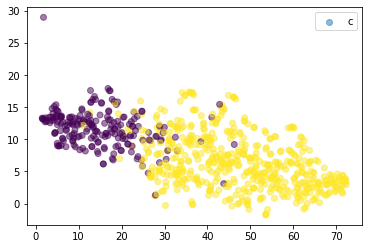

In [324]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[rr, 0], X_embedded[rr, 1], c=r, alpha=0.5, label='c')
ax.legend()
# plt.savefig("detail.png", dpi=500)
plt.show()

In [298]:
X_filtered = feat_train[rr,]

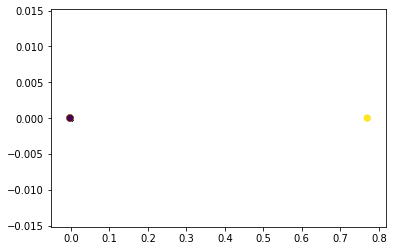

In [299]:
kpca = KernelPCA(n_components=128, kernel='rbf', gamma=0.01)
X_pca = kpca.fit_transform(X_filtered)

X_filtered = X_pca

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=r)
plt.show()

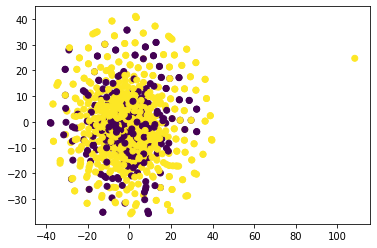

In [291]:
X_embedded_kpca = TSNE(n_components=2).fit_transform(X_pca)
plt.scatter(X_embedded_kpca[:, 0], X_embedded_kpca[:, 1], c=r)
plt.show()

In [300]:
from metric_learn import LMNN

lmnn = LMNN(k=3, init='auto', regularization=0.3)
lmnn.fit(X_filtered, r)

LMNN(convergence_tol=0.001, init='auto', k=3, learn_rate=1e-07, max_iter=1000,
     min_iter=50, n_components=None, num_dims='deprecated', preprocessor=None,
     random_state=None, regularization=0.3, use_pca='deprecated',
     verbose=False)

In [190]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric=lmnn.get_metric())
knn.fit(X_filtered, y_train_val)

knn.score(X_filtered, y_train_val)

0.9944736842105263

In [220]:
knn_init_data = KNeighborsClassifier(3)
knn_init_data.fit(X_filtered, y_train_val)
knn_init_data.score(X_filtered, y_train_val)

knn_init_data.score(feat_val, np.argmax(y_valid,axis=1))

0.9863157894736843

In [301]:
X_t = lmnn.transform(X_filtered)
X_embedded_transf = TSNE(n_components=2).fit_transform(X_t)

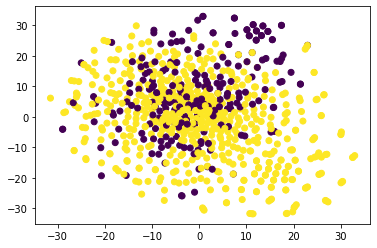

In [302]:
plt.scatter(X_embedded_transf[:, 0], X_embedded_transf[:, 1], c=r)
plt.show()

In [213]:
knn3 = KNeighborsClassifier(5)
knn3.fit(X_t, y_train_val)
knn3.score(X_t, y_train_val)

0.9944736842105263

In [207]:
X_v = lmnn.transform(feat_val)

In [215]:
knn3.score(X_v, np.argmax(y_valid,axis=1))

0.9873684210526316

In [192]:
knn.score(feat_val, np.argmax(y_valid,axis=1))

0.9873684210526316